In [1]:
# Purpose: Plotting the zonal mean and zonally-integrated heat uptake, 
#          sea surface temperature, surface air temperature, downward longwave
#          and downward shortwave radiation trends
#          - heat uptake from the simulations with full forcing, wind- and 
#            thermal-only forcing
#          - same for SSTs
#          - SAT, RLDS and RSDS from the JRA55-do-1-3 input fields
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 10. 12. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/'
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
from scipy import stats
from wrf import to_np # conversion to arrays required for arrows on maps                                

import warnings
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime


from cdo import *
cdo = Cdo()
import os
import sys

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

from dask.distributed import Client
client = Client(n_workers=16)
client

Client Scheduler: tcp://127.0.0.1:36785 Dashboard: /proxy/8787/status,Cluster Workers: 16 Cores: 16 Memory: 250.00 GiB


### Load in the data for the panels

In [2]:
%%time
# ---------------------------------------------------------------- #
exp = ['_PI_Offset_','_Wind_PI_Offset_','_TempRad_PI_Offset_']
out    = '1deg_jra55_iaf_branch2000_trend/'
qnet_fn = 'trend_net_sfc_heating_average_DT_iaf'
start_time = ['1972']; end_time = ['2017']
siconca = xr.open_dataset('/g/data/e14/mv7494/jra55-do/'+'siconca_jra55-do_mask.nc').siconca_jra_mask # mask with sea ice concentration > 15% 
ocean_grid = xr.open_dataset(base+'1deg_jra55_iaf_branch2000_PI_Offset/output200/ocean/ocean_grid.nc')
dxt_ACCESS = ocean_grid.dxt; dyt_ACCESS = ocean_grid.dyt
dxt_JRA = np.full(640, (6371e3*2*np.pi)/640) # circumference of the Earth divided by the number of lon grid cells
# ---------------------------------------------------------------- #

for f in range(3): # loop through the three simulations
    # load in Qnet spatial patterns (J m**-2 year**-1)
    Qnet = xr.open_dataset(base+out+qnet_fn+exp[f]+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc').net_sfc_heating.squeeze() # load in spatial trend
    Qnet = (Qnet*dxt_ACCESS).sum(['xt_ocean']).rolling(yt_ocean=10, center=True).mean() # multiply with zonal grid cell length & take 10-grid cell rolling mean
    # load in SST (°C year**-1)
    temp_access = xr.open_dataset(base+out+'trend_temp_iaf'+exp[f]+start_time[0]+'-'+end_time[0]+'.nc').temp[0,0,:,:]
    SST_trend = (temp_access*siconca.mean('time')).mean('xt_ocean').load() # multiply with sea ice mask & take zonal mean
    
    if f == 0:
        Qnet_full = Qnet; SST_trend_full = SST_trend
    if f == 1:
        Qnet_wind = Qnet; SST_trend_wind = SST_trend
    if f == 2:
        Qnet_thermal = Qnet; SST_trend_thermal = SST_trend

# next, create ocean-only mask
tos = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/land_sea_mask_320x640.nc').tos[0,:,:].fillna(0) # replace all nan with zeroes
landsea_mask = tos.where(tos>=0,1).where(tos<=0,1) # replace all non-zero data with ones

# surface air temperature anomalies
tas = xr.open_mfdataset('/g/data/e14/mv7494/JRA55-do-1-3/monthly_mean/JRA55-do-1-3_tas_monthly_mean_1958-2018_detrend.nc').tas
tas = (tas.groupby('time.month') - tas.groupby('time.month').mean('time'))
tas = tas*landsea_mask # only select ocean grid cells by multiplying with landsea_mask
tas = tas.mean(['lon']).groupby('time.year').mean('time').load()
tas_zonal = np.zeros(320)
# Wall time: 3.88 s

for f in range(320): # loop through the latitudes and write out the trends
    z1 = np.polyfit(tas.year, tas[:,f], 1) # intercept and trend
    tas_zonal[f] = z1[0]

CPU times: user 5.07 s, sys: 1.56 s, total: 6.63 s
Wall time: 16.6 s


### Load in radiation data

In [56]:
%%time
base_jra = '/g/data/e14/mv7494/JRA55-do-1-3/monthly_mean/'
# monthly mean data created by :history = "Thu Oct 28 21:29:24 2021: cdo -O -monmean -mergetime from the raw JRA55-do data set
rlds = xr.open_dataset(base_jra+'JRA55-do-1-3_rlds_monthly_mean_1958-2018.nc').rlds.sel(time=slice('1972','2017')) 
rsds = xr.open_dataset(base_jra+'JRA55-do-1-3_rsds_monthly_mean_1958-2018.nc').rsds.sel(time=slice('1972','2017'))

# only select flux over ocean, multiply with grid-cell zonal length & convert to J/m2 by multiplying with the number of seconds per month
rlds = (rlds*landsea_mask*dxt_JRA*60*60*24*30) 
rlds = (rlds.groupby('time.month') - rlds.groupby('time.month').mean('time')).sum(['lon']) # dimensions: (time: 552, lat: 320)
rsds = (rsds*landsea_mask*dxt_JRA*60*60*24*30)
rsds = (rsds.groupby('time.month') - rsds.groupby('time.month').mean('time')).sum(['lon'])


time = np.linspace(0,552,552) # I cannot use the rlds.time dimension as I get an error otherwise
rlds_zonal = np.zeros(320); rsds_zonal = np.zeros(320) # empty arrays which get filled up with the trends
for f in range(320): # loop through each latitude
    if f % 50 == 0:
        print('latitude '+str(f))
    z1 = np.polyfit(time, rlds[:,f], 1) # calculate linear trend
    rlds_zonal[f] = z1[0] * 12 # multiply by 12 to get annual trend instead of monthly trend and write into empty array
    z1 = np.polyfit(time, rsds[:,f], 1)
    rsds_zonal[f] = z1[0] * 12
# Wall time: 11.2 s

latitude 0
latitude 50
latitude 100
latitude 150
latitude 200
latitude 250
latitude 300
CPU times: user 5.96 s, sys: 6.33 s, total: 12.3 s
Wall time: 11 s


### Plotting routine

CPU times: user 1.11 s, sys: 63.3 ms, total: 1.17 s
Wall time: 1.04 s


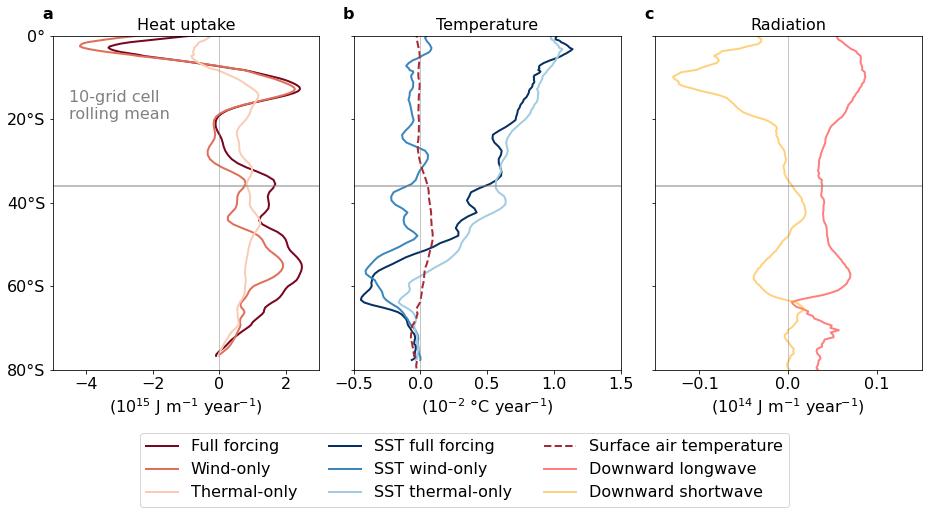

In [55]:
%%time
# initialise figure
fig = plt.figure(figsize=(13,6),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1,3, width_ratios=[1,1,1]) 
ylimit = [-80, 0] 

def fancy_panels(titel, xlab, panel_nr):
    # ax1.set_xlim(xlimit[0],xlimit[1])
    ax1.axvline(x=0, c = 'grey', linewidth = .5, alpha = .9); ax1.axhline(y=-36, c = 'grey', linewidth = 2, alpha=.5)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.locator_params(axis='x', nbins=5);
    # ---
    # legend including a legend title
    # plt.legend(fontsize=16, ncol=1)#, bbox_to_anchor=(.99, .05), loc='lower right') 
    plt.title(titel,fontsize=16)

    ax1.text(-.04, 1.05,panel_nr, transform=ax1.transAxes, size=16, weight='bold') # bold letter at the top
    ax1.set_xlabel(xlab, fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)

    ax1.set_ylim(ylimit[0],ylimit[1])
    ax1.locator_params(axis='x', nbins=5)
    ax1.locator_params(axis='y', nbins=7)

    labels = [item.get_text() for item in ax1.get_yticklabels()]     
    ax1.set_yticklabels(['80°S','60°S','40°S','20°S','0°'], fontsize=16)  
    # plt.legend(fontsize=16)

# panel 1: heat uptake data ----------------------------------------------------------------------------- 
ax1 = plt.subplot(gs[0,0]); xlimit = [-5,3] 

plt.plot(Qnet_full/1e15,Qnet_full.yt_ocean, linewidth=2, color=rotblau[1], label='Full forcing')
plt.plot(Qnet_wind/1e15,Qnet_full.yt_ocean, linewidth=2, color=rotblau[5], label='Wind-only')
plt.plot(Qnet_thermal/1e15,Qnet_full.yt_ocean, linewidth=2, color=rotblau[8], label='Thermal-only')
ax1.set_xlim(xlimit[0],xlimit[1])
plt.text(-4.5,-20,'10-grid cell\nrolling mean',fontsize=16,color='grey')

fancy_panels('Heat uptake','(10$^{15}$ J m$^{-1}$ year$^{-1}$)','a')
# plt.legend(ncol=1,fontsize=16, bbox_to_anchor=(.32, .2), loc='center') 

# panel 2: temperature data ----------------------------------------------------------------------------- 
ax1 = plt.subplot(gs[0,1]); xlimit = [-.5,1.5] 
            
plt.plot(SST_trend_full*1e2,SST_trend_full.yt_ocean, linewidth=2, color=rotblau[20], label='SST full forcing')

plt.plot(SST_trend_wind*1e2,SST_trend_full.yt_ocean, linewidth=2, color=rotblau[16], label='SST wind-only')
plt.plot(SST_trend_thermal*1e2,SST_trend_full.yt_ocean, linewidth=2, color=rotblau[13], label='SST thermal-only')
plt.plot(tas_zonal*1e2, tas.lat,  linewidth=2, color=rotblau[3], label = 'Surface air temperature', linestyle='--')
ax1.set_xlim(xlimit[0],xlimit[1])

fancy_panels('Temperature','(10$^{-2}$ °C year$^{-1}$)','b')
ax1.set_yticklabels([]) # no labels because I already have those on the left
# plt.legend(ncol=1,fontsize=16, bbox_to_anchor=(.72, .2), loc='center') 

# panel 3: radiation data ----------------------------------------------------------------------------- 
ax1 = plt.subplot(gs[0,2]); xlimit = [-.15,.15] 

plt.plot(rlds_zonal/1e14, rlds.lat,  linewidth=2, color='red', label='Downward longwave', alpha=.5)
plt.plot(rsds_zonal/1e14, rsds.lat,  linewidth=2, color='orange', label='Downward shortwave', alpha=.5)
ax1.set_xlim(xlimit[0],xlimit[1])

fancy_panels('Radiation','(10$^{14}$ J m$^{-1}$ year$^{-1}$)', 'c')
ax1.set_yticklabels([]) # no labels because I already have those on the left

fig.legend(ncol=3,fontsize=16, bbox_to_anchor=(.5, -.2), loc='lower center') 

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'Zonal_forcing_and_SST_trends', 
            dpi=300, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #
# Wall time: 20.6 s

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #

### New way to calculate zonal integral of downward long- and shortwave radiative trends

In [4]:
%%time
rlds = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/monthly_mean/'+
               'JRA55-do-1-3_rlds_monthly_mean_1958-2018_detrend.nc').rlds.sel(time=slice('1972','2017')) # monthly mean
rsds = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/monthly_mean/'+
               'JRA55-do-1-3_rsds_monthly_mean_1958-2018_detrend.nc').rsds.sel(time=slice('1972','2017')) # monthly mean
# only select flux over ocean, multiply with grid-cell zonal length, convert to J/m2 and take rolling mean over ten grid cells
rlds = (rlds*landsea_mask*dxt_JRA*60*60*24*30*552).sum(['lon']).rolling(lat=10, center=True).mean() 
rsds = (rsds*landsea_mask*dxt_JRA*60*60*24*30*552).sum(['lon']).rolling(lat=10, center=True).mean()


time = np.linspace(0,552,552)
rlds_zonal2 = np.zeros(320); rsds_zonal2 = np.zeros(320) # empty arrays which get filled up with the trends
for f in range(320):
#    if f % 20 == 0:
#        print('latitude '+str(f))
    z1 = np.polyfit(time, rlds[:,f], 1) # intercept and trend
    rlds_zonal2[f] = z1[0]
    z1 = np.polyfit(time, rsds[:,f], 1) # intercept and trend
    rsds_zonal2[f] = z1[0]
plt.plot(rlds_zonal2,rlds.lat)
plt.plot(rsds_zonal2,rsds.lat)

NameError: name 'dxt_JRA' is not defined

In [5]:
# %%time
# rlds = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/atmos/3hr/rlds/gn/v20180412/'+
#                  'rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_1958*').rlds * (60*60*3) # convert to J m^-2
# rlds = (rlds*landsea_mask*dxt_JRA) # only select flux over ocean
# rlds = (rlds.groupby('time.month') - rlds.groupby('time.month').mean('time')).sum(['lon'])
# rlds

# time = np.linspace(0,2920,2920)
# rlds_zonal2 = np.zeros(320); rsds_zonal2 = np.zeros(320) # empty arrays which get filled up with the trends
# for f in range(320):
#     if f % 20 == 0:
#         print('latitude '+str(f))
#     z1 = np.polyfit(time, rlds[:,f], 1) # intercept and trend
#     rlds_zonal2[f] = z1[0]
# #    z1 = np.polyfit(rsds.year, rsds[:,f], 1) # intercept and trend
# #    rsds_zonal[f] = z1[0]
# rlds_zonal2

In [ ]:
base_jra_rad = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/atmos/3hr/'
rlds = xr.open_mfdataset(base_jra_rad+'rlds/gn/v20180412/'+
                       'rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_*.nc').rlds.sel(time=slice('1972','2017')) * (60*60*3)
rlds = rlds.resample(time="1MS").mean(dim="time") # take monthly mean
# calculate anomalies, select only data over ocean and integrate over longitudes
rlds = ((rlds.groupby('time.month') - rlds.groupby('time.month').mean('time'))*landsea_mask*dxt_JRA).sum(['lon']) 

rsds = xr.open_mfdataset(base_jra_rad+'rsds/gn/v20180412/'+
                       'rsds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_*.nc').rsds.sel(time=slice('1972','2017')) * (60*60*3)
rsds = rsds.resample(time="1MS").mean(dim="time") # take monthly mean
rsds = ((rsds.groupby('time.month') - rsds.groupby('time.month').mean('time'))*landsea_mask*dxt_JRA).sum(['lon']) 


In [ ]:
# # load in downward long- and shortwave radiation anomalies (W m**-2) 
# dxt_JRA = np.full(640, (6371e3*2*np.pi)/640) # circumference of the Earth divided by the number of lon grid cells
# 
# rlds = xr.open_mfdataset('/g/data/e14/mv7494/JRA55-do-1-3/monthly_anom/JRA55-do-1-3_rlds_monthly_anom_1958-2018.nc').rlds
# rlds = rlds*(60*60*3) # 3-hourly fluxes, i.e. each time step is 60*60*3 s
#                       # converting from W m^-2 / 3h -> J m^-2
# rlds = (rlds*landsea_mask*dxt_JRA).sum(['lon']).groupby('time.year').mean('time').load()
# rsds = xr.open_mfdataset('/g/data/e14/mv7494/JRA55-do-1-3/monthly_anom/JRA55-do-1-3_rsds_monthly_anom_1958-2018.nc').rsds
# rsds = rsds*(60*60*3)
# rsds = (rsds*landsea_mask*dxt_JRA).sum(['lon']).groupby('time.year').mean('time').load()
# 
# rlds_zonal = np.zeros(320); rsds_zonal = np.zeros(320) # empty arrays which get filled up with the trends
# for f in range(320):
#     z1 = np.polyfit(rlds.year, rlds[:,f], 1) # intercept and trend
#     rlds_zonal[f] = z1[0]
#     z1 = np.polyfit(rsds.year, rsds[:,f], 1) # intercept and trend
#     rsds_zonal[f] = z1[0]
# # Wall time: 12.3 s